## Content-based Movie Recommendation System

### Libraries required
1. pandas to read the csv data.
2.  sklearn.metrics.pairwise to generate cosine similarity between users and movies.

In [1]:
#Importing Necessary Libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

### Load movie and ratings dataset, Merge on column 'movieId', filter high rated movies by the user

In [2]:
# Read the csv files
df1 = pd.read_csv('movies.csv', delimiter=',', header=0, encoding='utf-8', nrows=10000)
df2 = pd.read_csv('ratings.csv', delimiter=',', header=0, encoding='utf-8',nrows=10000)

In [3]:
# Merging movie and ratings datasets on the column movieId
merged_df = pd.merge(df1, df2, on='movieId')
merged_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517


In [11]:
# compute total rating of movies
top_10 = merged_df.groupby('title')[['rating']].sum().nlargest(10,'rating')
top_10.head()

,rating
title,
Star Wars: Episode IV - A New Hope (1977),175.0
Pulp Fiction (1994),160.0
"Shawshank Redemption, The (1994)",156.5
"Silence of the Lambs, The (1991)",155.0
Forrest Gump (1994),154.5


<BarContainer object of 10 artists>

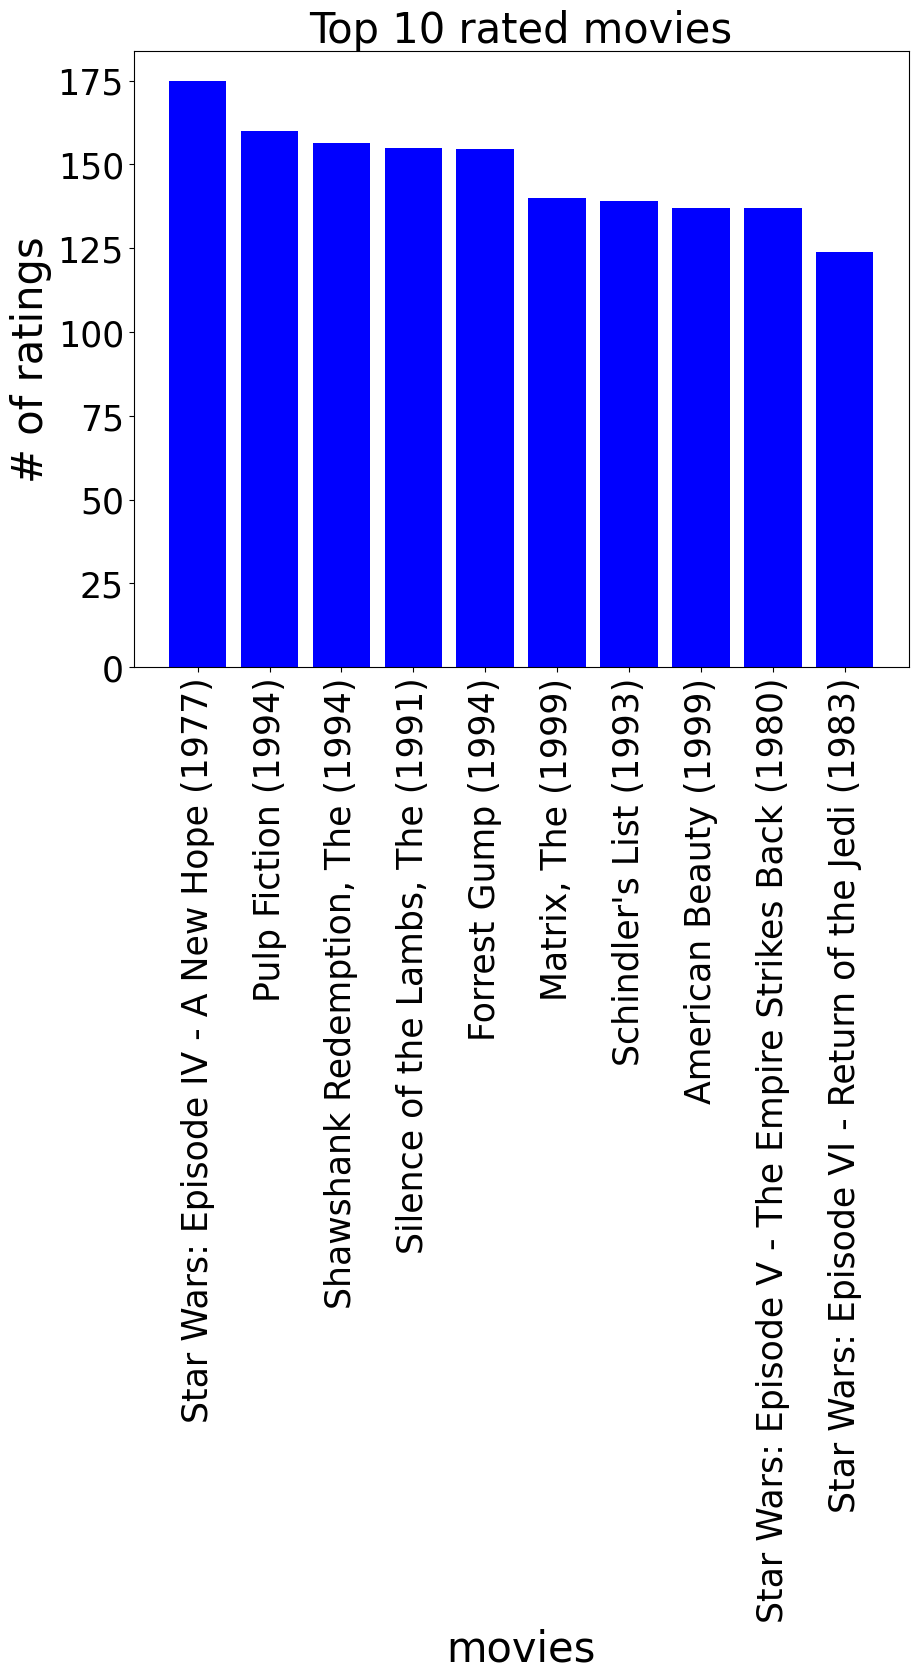

In [14]:
plt.figure(figsize=(10,8))
plt.title('Top 10 rated movies',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('movies',fontsize=30)
plt.ylabel('# of ratings',fontsize=30)

plt.bar(top_10.index,top_10['rating'],color='blue')

In [60]:
movie_mean_rating = pd.DataFrame(merged_df.groupby('title')['rating'].mean())
movie_mean_rating['count'] = pd.DataFrame(merged_df.groupby('title')['rating'].count())
movie_mean_rating.head()

,rating,count
title,,
'Round Midnight (1986),4.000000,1
"'burbs, The (1989)",2.500000,2
...And Justice for All (1979),2.500000,1
10 (1979),3.333333,3
10 Rillington Place (1971),3.500000,1


Text(0, 0.5, 'count')

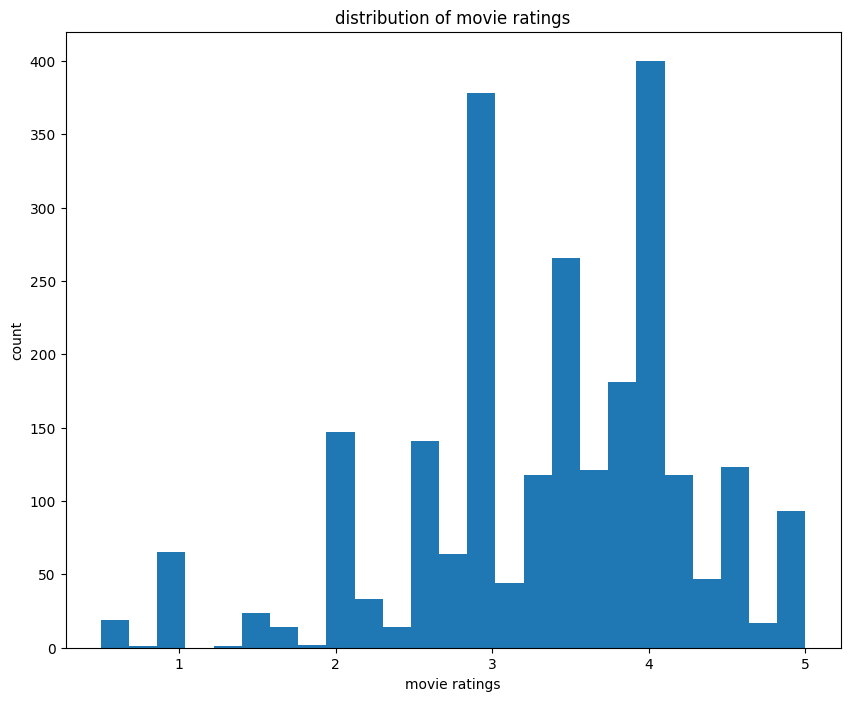

In [64]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = False
movie_mean_rating['rating'].hist(bins=25)
plt.grid(False)
plt.title('distribution of movie ratings')
plt.xlabel('movie ratings')
plt.ylabel('count')

In [ ]:
# Filter the dataset for movie rating > 3.5 to recommend high rated movies
high_ratings_df = merged_df[merged_df['rating'] > 3.5].copy()
high_ratings_df[high_ratings_df['rating']<3.5]

,movieId,title,genres,userId,rating,timestamp


In [ ]:
# Get the top genre for the movie
# high_ratings_df['genres'] = high_ratings_df['genres'].str.split('|').str[0]

### Create a Binary matrix with feature as genre to identify genres for each movie

In [ ]:
# Binary feature matrix for movie belonging to particular genre
genre_list = sorted(set([genre for genres in high_ratings_df['genres'].str.split('|') for genre in genres]))
for genre in genre_list:
    high_ratings_df[genre] = high_ratings_df['genres'].apply(lambda x: int(genre in x))

In [ ]:
# Create movie-genre feature matrix
movie_genre_df = high_ratings_df.groupby(['movieId'])[genre_list].max().reset_index()

### Get all high ratings associated with each unique user

In [ ]:
# Get dataframes with unique users and the rated movies by them 
for user in high_ratings_df['userId'].unique():
    user_ratings = high_ratings_df[high_ratings_df['userId'] == user]

### Group by userIds to generate each unique combination of userId-movieId


In [ ]:
# Group the high_ratings_df dataframe by userId
user_groups = high_ratings_df.groupby('userId')

### Apply cosine similarity between users rated-unrated movies to recommend movies as per similar genres

In [ ]:
# Loop over all user IDs and generate a list of recommended movies for each user
for user_id, user_ratings in user_groups:
    # Filter the high_ratings_df dataframe to only include movies that the user has not rated and similar genres
    unrated_movies = high_ratings_df[high_ratings_df['genres'].str.contains('|'.join(user_ratings['genres'].unique())) & 
                                     ~high_ratings_df['movieId'].isin(user_ratings['movieId'])]
    
    # Skip the current user if there are no unrated movies or if all unrated movies have missing genre information
    if unrated_movies.empty or unrated_movies[genre_list].isnull().all().all():
        continue
    
    # Create movie-genre feature matrix for unrated movies
    unrated_movie_genre_df = unrated_movies.groupby(['movieId'])[genre_list].max().reset_index()
    
    # Merge the user's ratings with the movie-genre feature matrix for unrated movies
    user_movie_genre_df = pd.merge(user_ratings[['movieId']], movie_genre_df, on='movieId', how='left')
    unrated_user_movie_genre_df = pd.merge(unrated_movies[['movieId']], unrated_movie_genre_df, on='movieId', how='left')
    
    # Replace missing values with 0 in the merged dataframes
    user_movie_genre_df.fillna(0, inplace=True)
    unrated_user_movie_genre_df.fillna(0, inplace=True)
    
    # Compute the cosine similarity between the user's ratings of watched or rated movies and all unrated movies
    user_genre_matrix = user_movie_genre_df[genre_list].values
    unrated_genre_matrix = unrated_user_movie_genre_df[genre_list].values
    user_cosine_sim = cosine_similarity(user_genre_matrix, unrated_genre_matrix)
    
    # Get the indices of the top recommended movies
    sim_scores = list(enumerate(user_cosine_sim.mean(axis=0)))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores if i[0] not in user_ratings['movieId'].tolist()]
    
    # Get the titles and genres of the top recommended movies, excluding the ones that have already been recommended to the user
    recommended_movies = []
    for index in top_indices:
        if unrated_movies.iloc[index]['title'] not in recommended_movies:
            recommended_movies.append((unrated_movies.iloc[index]['title'], unrated_movies.iloc[index]['genres']))
    
    # Print the list of recommended movies for the current user
    print(f"Recommendations for user {user_id}:")
    recommended_movies_set = set()
    for movie in recommended_movies:
        if movie[0] not in recommended_movies_set:
            print(f"\t{movie[0]} ({movie[1].split('|')})")
            recommended_movies_set.add(movie[0])
            if len(recommended_movies_set) >= 3:
                break


Recommendations for user 1:
	Nixon (1995) (['Drama'])
	Dangerous Minds (1995) (['Drama'])
	Cry, the Beloved Country (1995) (['Drama'])
Recommendations for user 2:
	Revolutionary Girl Utena: Adolescence of Utena (a.k.a. Revolutionary Girl Utena the Movie) (Shoujo kakumei Utena: Adolescence mokushiroku) (1999) (['Action', 'Adventure', 'Animation', 'Comedy', 'Drama', 'Fantasy', 'Romance'])
	Three Kings (1999) (['Action', 'Adventure', 'Comedy', 'Drama', 'War'])
	White Squall (1996) (['Action', 'Adventure', 'Drama'])
Recommendations for user 3:
	RoboCop 3 (1993) (['Action', 'Crime', 'Drama', 'Sci-Fi', 'Thriller'])
	RoboCop (1987) (['Action', 'Crime', 'Drama', 'Sci-Fi', 'Thriller'])
	Strange Days (1995) (['Action', 'Crime', 'Drama', 'Mystery', 'Sci-Fi', 'Thriller'])
Recommendations for user 4:
	Fifth Element, The (1997) (['Action', 'Adventure', 'Comedy', 'Sci-Fi'])
	Space Cowboys (2000) (['Action', 'Adventure', 'Comedy', 'Sci-Fi'])
	Innerspace (1987) (['Action', 'Adventure', 'Comedy', 'Sci-F

Recommendations for user 37:
	Crossing Guard, The (1995) (['Action', 'Crime', 'Drama', 'Thriller'])
	Clear and Present Danger (1994) (['Action', 'Crime', 'Drama', 'Thriller'])
	Face/Off (1997) (['Action', 'Crime', 'Drama', 'Thriller'])
Recommendations for user 38:
	Nixon (1995) (['Drama'])
	Dangerous Minds (1995) (['Drama'])
	Cry, the Beloved Country (1995) (['Drama'])
Recommendations for user 39:
	The Count of Monte Cristo (2002) (['Action', 'Adventure', 'Drama', 'Thriller'])
	White Squall (1996) (['Action', 'Adventure', 'Drama'])
	Ben-Hur (1959) (['Action', 'Adventure', 'Drama'])
Recommendations for user 40:
	Crossing Guard, The (1995) (['Action', 'Crime', 'Drama', 'Thriller'])
	Clear and Present Danger (1994) (['Action', 'Crime', 'Drama', 'Thriller'])
	Face/Off (1997) (['Action', 'Crime', 'Drama', 'Thriller'])
Recommendations for user 41:
	The Count of Monte Cristo (2002) (['Action', 'Adventure', 'Drama', 'Thriller'])
	City of God (Cidade de Deus) (2002) (['Action', 'Adventure', 'Cr

Recommendations for user 74:
	Fargo (1996) (['Comedy', 'Crime', 'Drama', 'Thriller'])
	Freeway (1996) (['Comedy', 'Crime', 'Drama', 'Thriller'])
	Get Shorty (1995) (['Comedy', 'Crime', 'Thriller'])
Recommendations for user 75:
	Tequila Sunrise (1988) (['Action', 'Drama', 'Romance', 'Thriller'])
	True Lies (1994) (['Action', 'Adventure', 'Comedy', 'Romance', 'Thriller'])
	Lara Croft Tomb Raider: The Cradle of Life (2003) (['Action', 'Adventure', 'Comedy', 'Romance', 'Thriller'])
